In [4]:
import numpy as np
import matplotlib.pyplot as plt

from typing import Optional
from timeit import default_timer as timer

np.random.seed(42)  # Set seed
plt.style.use('dark_background')  # Dark mode

## Cayley transform calculation

#### Benchmark calculation speed for Cayley transform
Cayley transform is calculated as follows.

\begin{align}
\phi_{\nu}(X) = (I - \nu X)^{-1} \cdot (I + \nu X) \hspace{12pt} | \hspace{6pt} X^T = -X
\end{align}

The corresponding descent curve on the Stieffel manifold.

\begin{align}
    X^n(\nu) = \phi_{\nu}(W^n) \cdot X^{n-1} \hspace{12pt} | \hspace{6pt} W^n = \nabla X X^T - X \nabla X^T
\end{align}

The time complexity of this is $\mathcal{O}(2 \cdot N^3) \rightarrow X\in \mathbb{R}^{N x R}$. <br>
$\mathcal{O}(N^3)$ from the matrix inversion and $\mathcal{O}(N^3)$ from the matrix multiplication

In [2]:
def phi(x, nu):
    return np.linalg.inv(np.eye(size) - nu * x) @ (np.eye(size) + nu * x)

Calculate with fixed point iteration. <br>
\begin{gather}
(I - \nu X) \cdot \phi_{\nu}(X) = (I + \nu X) \\
\phi_{\nu}(X)  = (I + \nu X) + \nu X \cdot \phi_{\nu}(X) \\
\phi_{\nu}(X)  = I + \nu X \cdot (I + \phi_{\nu}(X))
\end{gather}

Calculate iteratively 
1. $\phi^0_{\nu} \leftarrow I + \nu X$ <br>
2. $\phi_{\nu}^k \leftarrow I + \nu X \cdot (I + \phi_{\nu}^{k-1})$

The time complexity of this is $\mathcal{O}(s \cdot N^3) \rightarrow X\in \mathbb{R}^{N x R}$. <br>
$s$ times $\mathcal{O}(N^3)$ from the matrix multiplication in each iteration

In [63]:
def fp_phi(X, nu, s):
    Y = np.eye(size) + nu * X 
    for i in range(s):
        Y = np.eye(size) + nu * X@(np.eye(size) + Y)
    return Y

Combined function

In [7]:
def cayley(x, nu, s: Optional[int]):
    size = x.shape[0]
    y = np.eye(size) + nu * x
    if s is None:
        y = np.linalg.inv(np.eye(size) - nu * x) @ y
    else:
        assert s > -1 
        for _ in range(s):
            y = np.eye(size) + nu * x@(np.eye(size) + y)

Woodbury-Morrison formula
\begin{gather}
\phi_{\nu}(X) = I + \chi_{\nu}(X) \\
\chi_{\nu}(X) = -\nu A \cdot (I + \frac{\nu}{2}B^TA)^{-1}B^T \\
A = [\nabla X, X] \\
B = [X, -\nabla X]
\end{gather}

In [73]:
def chi(X, nu):
    """Calculate additive part of  phi = I + chi given a variable and it's gradient."""
    a = tf.concat([grad, var], axis=1)
    b = tf.concat([var, -grad], axis=1)
    skew = tf.transpose(b) @ a
    c = tf.eye(skew.shape[0]) + nu / 2 * skew
    skew_inv = tf.linalg.inv(c, adjoint=False)
    return -nu * a @ skew_inv @ tf.transpose(b)

Fixed point iteration <br>
\begin{align}
(I - \nu X) \cdot (I + \chi_{\nu}(X)) = (I + \nu X) \\
I + \chi_{\nu}(X) = (I + \nu X) + \nu X \cdot (I + \chi_{\nu}(X)) \\
\chi_{\nu}(X)  = I + \nu X \cdot (2I + \chi_{\nu}(X))
\end{align}

Calculate iteratively 
1. $\chi^0_{\nu} \leftarrow \nu X$ <br>
2. $\chi_{\nu}^k \leftarrow I + \nu X \cdot (2I + \chi_{\nu}^{k-1})$

In [74]:
def fp_chi(X, nu, s):
    Y = nu * X
    for i in range(s):
        Y = np.eye(size) + nu * X@(2*np.eye(size) + Y)
    return Y

In [75]:
# Initialize matrices
size = 2**2
nu = 10e-4

# test function
A = np.random.random((size, size))
X = A.T - A
Y = phi(X, nu)
kappa(Y)

3.5108338777944003e-16

In [76]:
# Depth of testing
depth = 11
# Sizes to test
sizes = [2**i for i in range(depth)]
# time calculation
times = 100

In [77]:
timings = [[None] * times for i in range(depth)]

for i, size in enumerate(sizes):
    A = np.random.random((size, size))
    X = A.T - A
    for j in range(times):
        start = timer()
        Y = phi(X, nu)
        end = timer()
        timings[i][j] = end - start

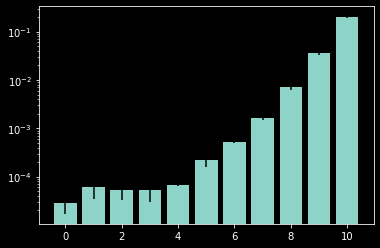

In [78]:
plt.bar(x=range(depth), height=[np.mean(t) for t in timings], yerr=[np.std(t) for t in timings])
plt.yscale('log')
plt.show()

In [79]:
s = [i + 1 for i in range(10)]
y = [fp_phi(X, nu, i) for i in s]

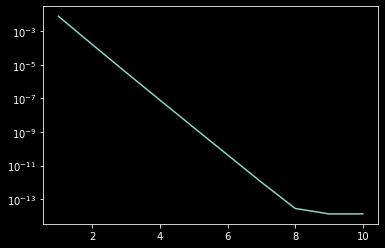

In [80]:
plt.plot(s, [np.linalg.norm(Y - Y_) for Y_ in y])
plt.yscale('log')
plt.show()

In [81]:
# time calculation
timings_fp = [[None] * times for i in range(depth)]

for i, size in enumerate(sizes):
    A = np.random.random((size, size))
    X = A.T - A
    for j in range(times):
        start = timer()
        Y = fp_phi(X, nu, 4)
        end = timer()
        timings_fp[i][j] = end - start

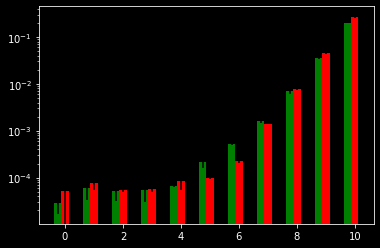

In [82]:
plt.bar(x=np.arange(depth) - 0.25, width=0.25, height=[np.mean(t) for t in timings], yerr=[np.std(t) for t in timings], color='green')
plt.bar(x=np.arange(depth), width=0.25, height=[np.mean(t) for t in timings_fp], yerr=[np.std(t) for t in timings_fp], color='red')
plt.yscale('log')
plt.show()